code 2 - Transformers


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from sklearn.metrics import precision_score, recall_score, f1_score

# Function to read data from files
def read_data(normal_logs, abnormal_logs):
    data, labels = [], []
    for filepath in normal_logs:
        with open(filepath) as fp:
            for line in fp:
                content = line.strip()
                data.append(content)
                labels.append(0)
    for filepath in abnormal_logs:
        with open(filepath) as fp:
            for line in fp:
                content = line.strip()
                data.append(content)
                labels.append(1)
    return data, np.array(labels)

# Function to load GloVe embeddings
def load_glove_embeddings(path):
    embeddings_index = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Function to create embedding matrix
def create_embedding_matrix(word_index, embeddings_index, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    new_word_index = {}
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            new_word_index[word] = i
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, new_word_index, len(new_word_index) + 1

# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

# Building the Transformer Model
def build_transformer_model(vocab_size, embedding_dim, max_len, embedding_matrix):
    inputs = Input(shape=(max_len,))
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len,
                  weights=[embedding_matrix[:vocab_size]], trainable=False)(inputs)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
    x = GlobalAveragePooling1D()(x)
    x = Dense(400, activation='relu')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(2, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to evaluate the model using precision, recall, and F1 score
def evaluate_model(model, test_data, test_labels):
    predictions = model.predict(test_data)
    predicted_labels = np.argmax(predictions, axis=1)
    precision = precision_score(test_labels, predicted_labels)
    recall = recall_score(test_labels, predicted_labels)
    f1 = f1_score(test_labels, predicted_labels)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

# Define paths
normal_train_paths = ["/home/aks/AOS-Project/filter/ceph-dout-filter.txt", "/home/aks/AOS-Project/filter/glustrefs_info-filter.txt", "/home/aks/AOS-Project/filter/daos-debug-filter.txt","/home/aks/AOS-Project/filter/orangefs-debug-filter.txt","/home/aks/AOS-Project/filter/beegfs-debug-filter.txt","/home/aks/AOS-Project/filter/hive-debug-filter.txt"]
abnormal_train_paths = ["/home/aks/AOS-Project/filter/ceph-derr-filter.txt", "/home/aks/AOS-Project/filter/glustrefs_error-filter.txt", "/home/aks/AOS-Project/filter/daos-error-filter.txt", "/home/aks/AOS-Project/filter/orangefs-error-filter.txt","/home/aks/AOS-Project/filter/beegfs-error-filter.txt","/home/aks/AOS-Project/filter/hive-error-filter.txt"]
normal_test_paths = ["/home/aks/AOS-Project/filter/lustre-debug-filter.txt","/home/aks/AOS-Project/filter/hbase-debug-filter.txt","/home/aks/AOS-Project/filter/hdfs-debug-filter.txt"]
abnormal_test_paths = ["/home/aks/AOS-Project/filter/lustre-error-filter.txt","/home/aks/AOS-Project/filter/hbase-error-filter.txt","/home/aks/AOS-Project/filter/hdfs-error-filter.txt"]
glove_path = '/home/aks/DRILL/glove-embeddings/glove.6B.100d.txt'

# Load and prepare data
train_data, train_labels = read_data(normal_train_paths, abnormal_train_paths)
test_data, test_labels = read_data(normal_test_paths, abnormal_test_paths)

# Tokenization and Embedding Setup
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data + test_data)
embeddings_index = load_glove_embeddings(glove_path)
embedding_dim = 100
embedding_matrix, new_word_index, vocab_size = create_embedding_matrix(tokenizer.word_index, embeddings_index, embedding_dim)
tokenizer.word_index = new_word_index
tokenizer.num_words = vocab_size

# Prepare sequences
max_len = 100
train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)
train_padded = pad_sequences(train_sequences, maxlen=max_len)
test_padded = pad_sequences(test_sequences, maxlen=max_len)

# Build and train the Transformer model
model = build_transformer_model(vocab_size, embedding_dim, max_len, embedding_matrix)
model.summary()
history = model.fit(train_padded, train_labels, epochs=5, validation_data=(test_padded, test_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_padded, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Evaluate precision, recall, and F1
evaluate_model(model, test_padded, test_labels)

2024-04-24 23:33:54.087189: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 23:33:54.181745: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 23:33:54.212147: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 23:33:54.577815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     387600      ['input_1[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 100, 100)    200         ['embedding[0][0]']              
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 100, 100)    103268      ['layer_normalization[0][0]',

2024-04-24 23:34:04.482765: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1037/1037 [==============================] - 18s 15ms/step - loss: 0.4160 - accuracy: 0.8212 - val_loss: 0.5384 - val_accuracy: 0.7482
Epoch 2/5
1037/1037 [==============================] - 14s 13ms/step - loss: 0.3631 - accuracy: 0.8482 - val_loss: 0.5722 - val_accuracy: 0.7373
Epoch 3/5
1037/1037 [==============================] - 14s 13ms/step - loss: 0.3467 - accuracy: 0.8584 - val_loss: 0.6940 - val_accuracy: 0.7305
Epoch 4/5
1037/1037 [==============================] - 15s 14ms/step - loss: 0.3323 - accuracy: 0.8662 - val_loss: 0.6216 - val_accuracy: 0.7632
Epoch 5/5
237/237 [==============================] - 2s 6ms/step - loss: 0.6485 - accuracy: 0.7550
Test Loss: 0.6484907269477844
Test Accuracy: 0.7549967169761658
237/237 [==============================] - 2s 6ms/step
Precision: 0.8691426587990281
Recall: 0.6294620412267471
F1 Score: 0.7301355882781747


In [2]:
model.save('my_model_transform.h5')

166/166 [==============================] - 2s 9ms/step - loss: 0.7138 - accuracy: 0.7339
Lustre Test Loss: 0.7137891054153442
Lustre Test Accuracy: 0.7338998913764954
35/35 [==============================] - 0s 8ms/step - loss: 1.1162 - accuracy: 0.6058
Hdfs Test Loss: 1.1162317991256714
Hdfs Test Accuracy: 0.6058394312858582
63/63 [==============================] - 1s 8ms/step - loss: 0.2704 - accuracy: 0.8849
Hbase Test Loss: 0.27037984132766724
Hbase Test Accuracy: 0.884902834892273


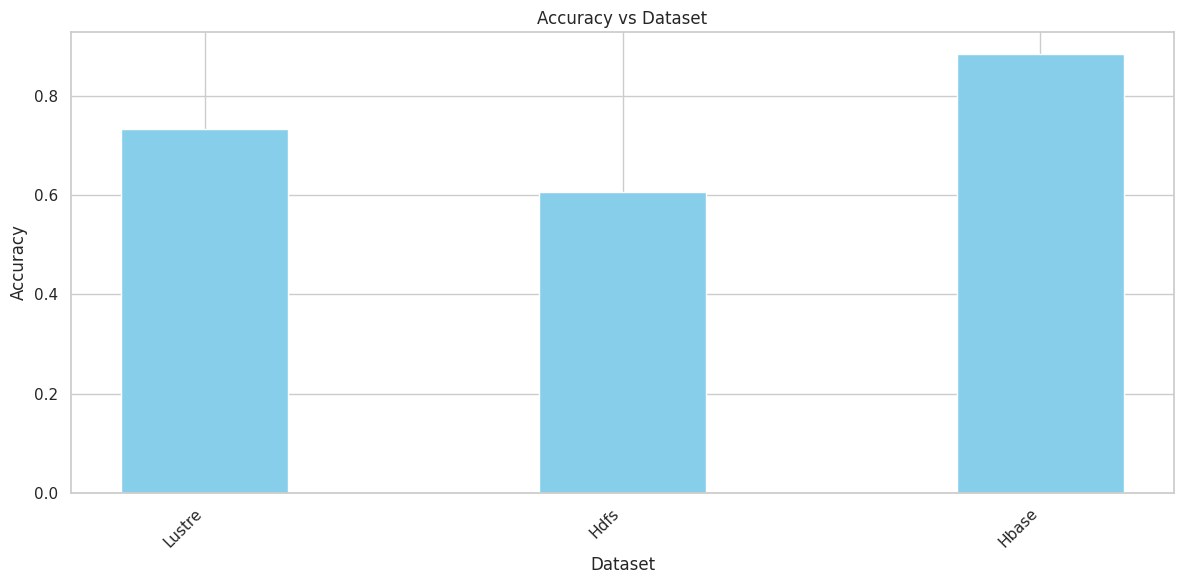

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
import seaborn as sns

sns.set(style="whitegrid")

model = load_model('my_model_transform.h5')

lustre_normal_test_paths = ["/home/aks/DRILL/sentilog/filter/lustre-debug-filter.txt"]
hdfs_normal_test_paths = ["/home/aks/DRILL/sentilog/filter/hdfs-debug-filter.txt"]
hbase_normal_test_paths = ["/home/aks/DRILL/sentilog/filter/hbase-debug-filter.txt"]

lustre_abnormal_test_paths = ["/home/aks/DRILL/sentilog/filter/lustre-error-filter.txt"]
hdfs_abnormal_test_paths = ["/home/aks/DRILL/sentilog/filter/hbase-error-filter.txt"]
hbase_abnormal_test_paths = ["/home/aks/DRILL/sentilog/filter/hdfs-error-filter.txt"]


lustre_test_data, lustre_test_labels = read_data(lustre_normal_test_paths, lustre_abnormal_test_paths)
hdfs_test_data, hdfs_test_labels = read_data(hdfs_normal_test_paths, hdfs_abnormal_test_paths)
hbase_test_data, hbase_test_labels = read_data(hbase_normal_test_paths, hbase_abnormal_test_paths)

lustre_test_sequences = tokenizer.texts_to_sequences(lustre_test_data)
hdfs_test_sequences = tokenizer.texts_to_sequences(hdfs_test_data)
hbase_test_sequences = tokenizer.texts_to_sequences(hbase_test_data)

max_len = 100

lustre_test_padded = pad_sequences(lustre_test_sequences, maxlen=max_len)
hdfs_test_padded = pad_sequences(hdfs_test_sequences, maxlen=max_len)
hbase_test_padded = pad_sequences(hbase_test_sequences, maxlen=max_len)

lustre_test_loss, lustre_test_acc = model.evaluate(lustre_test_padded, lustre_test_labels)
print("Lustre Test Loss:", lustre_test_loss)
print("Lustre Test Accuracy:", lustre_test_acc)

hdfs_test_loss, hdfs_test_acc = model.evaluate(hdfs_test_padded, hdfs_test_labels)
print("Hdfs Test Loss:", hdfs_test_loss)
print("Hdfs Test Accuracy:", hdfs_test_acc)

hbase_test_loss, hbase_test_acc = model.evaluate(hbase_test_padded, hbase_test_labels)
print("Hbase Test Loss:", hbase_test_loss)
print("Hbase Test Accuracy:", hbase_test_acc)

dataset_accuracies = {}

dataset_accuracies["Lustre"] = lustre_test_acc
dataset_accuracies["Hdfs"] = hdfs_test_acc
dataset_accuracies["Hbase"] = hbase_test_acc

datasets = list(dataset_accuracies.keys())
accuracies = list(dataset_accuracies.values())
plt.figure(figsize=(12, 6))  
plt.bar(datasets, accuracies, color='skyblue', width=0.4)  
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Dataset')
plt.xticks(rotation=45, ha="right")  
plt.tight_layout() 
plt.show()